In [5]:
import numpy as np
import math
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageChops
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

Using TensorFlow backend.


In [13]:
cellsize = 100

def readFont(ttx):
    letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
    letters += [chr(i) for i in range(ord('a'), ord('z')+1)]
    letters += ['zero','one','two','three','four','five','six','seven','eight','nine']
    numletters = len(letters)

    xMin = np.zeros(numletters, int)
    xMax = np.zeros(numletters, int)
    yMin = np.zeros(numletters, int)
    yMax = np.zeros(numletters, int)
    points= np.zeros(numletters, int)
    contours = np.zeros(numletters, int)

    #read overall ranges
    for i in range(0, numletters):
        glyph = ttx.find(r".//TTGlyph[@name='"+letters[i]+"']")
        xMin[i] = int(glyph.get('xMin'))
        xMax[i] = int(glyph.get('xMax'))
        yMin[i] = int(glyph.get('yMin'))
        yMax[i] = int(glyph.get('yMax'))
        for contour in glyph.iterfind('contour'):
            points[i] += len(list(contour.iterfind('pt')))
            contours[i]+=1

    xSize = xMax - xMin
    ySize = yMax - yMin
    print('xMin min/max/avg:', xMin.min(), xMin.max(), xMin.mean())
    print('xSize min/max/avg:', xSize.min(), xSize.max(), xSize.mean())
    print('points min/max/avg:', points.min(), points.max(), points.mean())
    print('contours min/max/avg:', contours.min(), contours.max(), contours.mean())

    outputdim = points.max()+contours.max()
    return letters, outputdim

#return angle scaled to [-1,1], and distance scaled similarly
def angleDist(p1,p2, hidden):
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    maxDim = 1500
    return math.atan2(dy,dx)/math.pi, math.sqrt(dx**2 + dy**2) * (-1 if hidden else 1) / maxDim  #negative distance means hidden

#read the actual points
def setupInputOutput(ttx, letters, outputdim):
    #output is array of letters x points x 2 (angle in radians, distance)
    #use float according to https://github.com/fchollet/keras/issues/2218
    numletters = len(letters)
    Y = np.zeros((numletters, outputdim*2), np.float32)
    for i, l in enumerate(letters):
        glyph = ttx.find(r".//TTGlyph[@name='"+l+"']")
        p=0 #point count across all contours (shapes)
        startp = (0,0)

        #ttx contours are areas within the letter, like the outside and inside of an O
        for contour in glyph.iterfind('contour'):
            pts = contour.iterfind('pt')
            xy = [(int(pt.get('x')), int(pt.get('y'))) for pt in pts]
            #should i read the ttx 'on' attribute too? can't find documentation for it, might be related to bezier control points by observation

            #fill output matrix

            #start with hidden line to start position
            Y[i][p], Y[i][p+1] = angleDist(startp, xy[0], True)
            startp = xy[0]
            p+=2

            #then between points
            for n in range(len(xy)-1):
                Y[i][p], Y[i][p+1] = angleDist(xy[n],xy[n+1], False)
                p+=2
        
            #finally wrap last point to first in contour
            N=len(xy)-1
            Y[i][p], Y[i][p+1] = angleDist(xy[N],xy[0], False)
            p+=2


    #input is 'one-hot' array of bool, one per letter
    X = np.identity(numletters, dtype=bool)

    return X,Y


def drawAllLetters(Y):
    rows = 5
    columns = math.ceil(Y.shape[0]/rows)
    def drawPoints(im, points):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.8
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(Y.shape[0]):
        y,x = divmod(i, columns)
        x *= cellsize
        y = (y+1)*cellsize-1
        points = []
        for j in range(0, Y.shape[1], 2):
            angle = Y[i][j]
            dist = Y[i][j+1]
            x2 = x+ abs(dist)*math.cos(angle*math.pi)*scale
            y2 = y- abs(dist)*math.sin(angle*math.pi)*scale
            if dist>0:
                points += (x2,y2)
            elif len(points)>2:
                im = drawPoints(im, points)
                points=[]
            x=x2
            y=y2
    if len(points)>2:
        im = drawPoints(im, points)
    return im



setup...
xMin min/max/avg: -230 215 37.3870967742
xSize min/max/avg: 441 2220 1055.64516129
points min/max/avg: 22 100 53.3064516129
contours min/max/avg: 1 3 1.40322580645


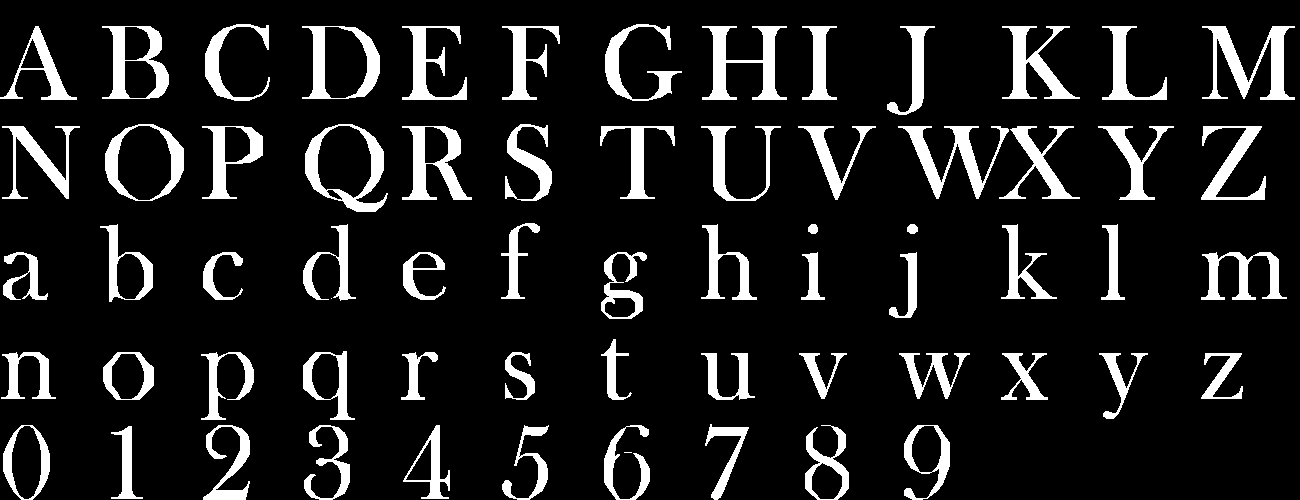

In [16]:
print('setup...')
ttx = ET.parse(r'deeper/BASKVILL.ttx') #read font data dumped from TrueType using fonttools
letters, outputdim = readFont(ttx)
X,Y = setupInputOutput(ttx, letters, outputdim)
drawAllLetters(Y)

In [45]:
print('compile model...')
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
#model.add(Dense(600, activation='relu'))
model.add(Dense(outputdim*2))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

print('fit the model...')
model.fit(X, Y, epochs=500, batch_size=len(letters))

compile model...
fit the model...
Epoch 1/500
62/62 [==============================] - 0s - loss: 0.1005 - acc: 0.0000e+00
Epoch 2/500
62/62 [==============================] - 0s - loss: 0.0971 - acc: 0.0000e+00
Epoch 3/500
62/62 [==============================] - 0s - loss: 0.0951 - acc: 0.0000e+00
Epoch 4/500
62/62 [==============================] - 0s - loss: 0.0936 - acc: 0.0000e+00
Epoch 5/500
62/62 [==============================] - 0s - loss: 0.0924 - acc: 0.0000e+00
Epoch 6/500
62/62 [==============================] - 0s - loss: 0.0913 - acc: 0.0161
Epoch 7/500
62/62 [==============================] - 0s - loss: 0.0904 - acc: 0.0161
Epoch 8/500
62/62 [==============================] - 0s - loss: 0.0895 - acc: 0.0161
Epoch 9/500
62/62 [==============================] - 0s - loss: 0.0887 - acc: 0.0161
Epoch 10/500
62/62 [==============================] - 0s - loss: 0.0879 - acc: 0.0161
Epoch 11/500
62/62 [==============================] - 0s - loss: 0.0872 - acc: 0.0161
Epoch 12/

evaluate the model...
32/62 [==============>...............] - ETA: 0s
acc: 24.19%
predict...
32/62 [==============>...............] - ETA: 0s
[ 0.         -0.96066666  1.          0.43799999  0.5         0.01533333
  0.02853544  0.05957255  0.17862386  0.02756003  0.17872898  0.04883077
  0.5         0.046       0.5         0.02733333  0.62270653  0.04964317
  0.62242347  0.0302067 ]
[-0.00364305 -0.97410727  0.98758692  0.4486655   0.49992698  0.00830282
  0.03743885  0.04203662  0.18755464  0.03542347  0.19365522  0.04262783
  0.50638968  0.05356819  0.51151174  0.03381464  0.64172554  0.04504405
  0.63179916  0.04411813]


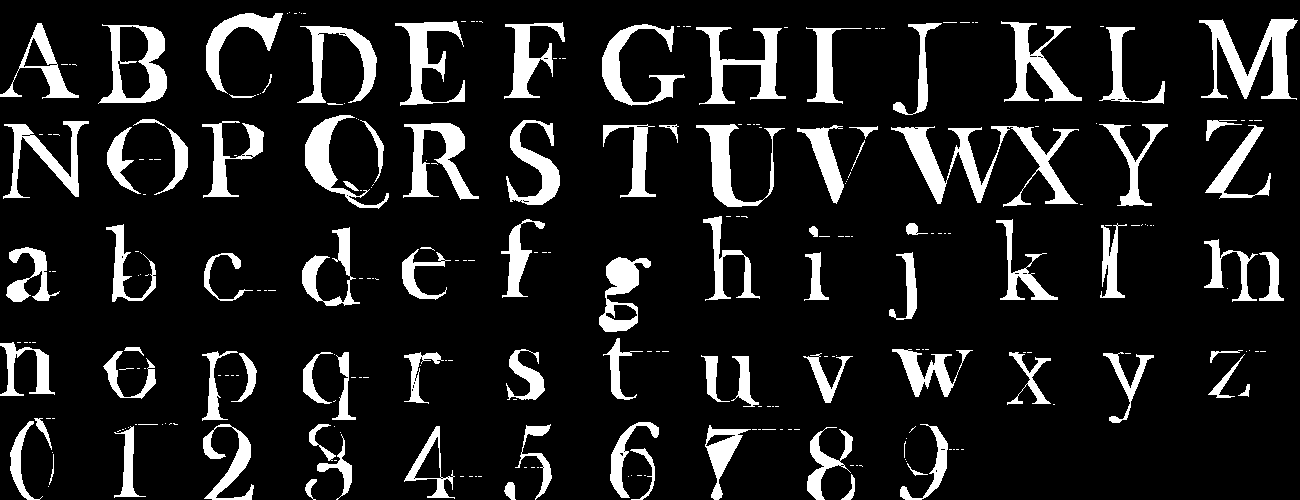

In [46]:
print('evaluate the model...')
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print('predict...')
newY = model.predict(X, verbose=1)

print()
print(Y[0][:20])
print(newY[0][:20])
drawAllLetters(newY)